---
title: "Coding Neural Network Part 5 - Dropout"
subtitle: "What is Dropout, its use, and how to implement it?"
date: "2018-05-20"
image: "feature.png"
categories: ["Machine Learning", "Deep Learning"]
format:
  html:
    code-fold: true
    code-tools: true
jupyter: python3
---

![](feature.png){fig-align="center" width="400" height="400"}

## Introduction

**Dropout** is a regularization technique. On each iteration, we randomly shut down some neurons (units) on each layer and don't use those neurons in both forward propagation and back-propagation. Since the units that will be dropped out on each iteration will be random, the learning algorithm will have no idea which neurons will be shut down on every iteration; therefore, force the learning algorithm to spread out the weights and not focus on some specific feattures (units). 
Moreover, dropout help improving generalization error by:

- Since we drop some units on each iteration, this will lead to smaller network which in turns means simpler network (regularization).
- Can be seen as an approximation to bagging techniques. Each iteration can be viewed as different model since we're dropping randomly different units on each layer. This means that the error would be the average of errors from all different models (iterations). Therefore, averaging errors from different models especially if those errors are uncorrelated would reduce the overall errors. In the worst case where errors are perfectly correlated, averaging among all models won't help at all; however, we know that in practice errors have some degree of uncorrelation. As result, it will always improve generalization error.

We can use different probabilities on each layer; however, the output layer would always have `keep_prob = 1` and the input layer has high `keep_prob` such as 0.9 or 1. If a hidden layer has `keep_prob = 0.8`, this means that; on each iteration, each unit has 80% probablitity of being included and 20% probability of being dropped out.

Dropout is used a lot in computer vision problems because we have a lot of features and not a lot of data. Also, features (pixels) next to each other usually don't add a lot of information. Therefore, models always suffer from overfitting.

To illustrate how dropout helps us reduce generalization error, we'll use the same dataset we've used in the previous notebooks. The dataset has images for cats and non-cat. We'll try to build a neural network to classify if the image has cat or not. Each image is 64 x 64 pixels on RGB scale. Let's import the data and take a look at the shape as well as a sample of a cat image from the training set.

In [1]:
# | echo: false
%load_ext lab_black

In [2]:
# | output: false
import os
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# local modules
sys.path.append("../../scripts/")
from coding_neural_network_from_scratch import (
    initialize_parameters,
    linear_activation_forward,
    compute_cost,
    linear_activation_backward,
    update_parameters,
    accuracy,
)

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (12, 6)

/Users/imad/anaconda3/envs/dl/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training data dimensions:
X's dimension: (12288, 209), Y's dimension: (1, 209)
Test data dimensions:
X's dimension: (12288, 50), Y's dimension: (1, 50)


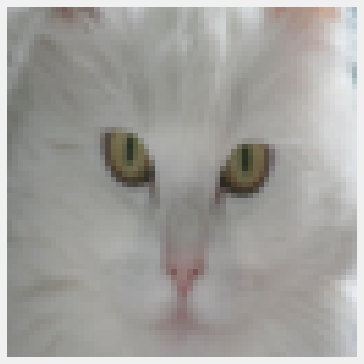

In [3]:
# Import training data
train_dataset = h5py.File("../../data/train_catvnoncat.h5")
X_train = np.array(train_dataset["train_set_x"])
Y_train = np.array(train_dataset["train_set_y"])

# Plot a sample image
plt.imshow(X_train[50])
plt.axis("off")

# Import test data
test_dataset = h5py.File("../../data/test_catvnoncat.h5")
X_test = np.array(test_dataset["test_set_x"])
Y_test = np.array(test_dataset["test_set_y"])

# Transform data
X_train = X_train.reshape(209, -1).T
X_train = X_train / 255
Y_train = Y_train.reshape(-1, 209)

X_test = X_test.reshape(50, -1).T
X_test = X_test / 255
Y_test = Y_test.reshape(-1, 50)

# print the new shape of both training and test datasets
print("Training data dimensions:")
print("X's dimension: {}, Y's dimension: {}".format(X_train.shape, Y_train.shape))
print("Test data dimensions:")
print("X's dimension: {}, Y's dimension: {}".format(X_test.shape, Y_test.shape))

## Implementation

Now, we'll write the functions needed to apply dropout on both forward propagation and back-propagation. Note that we'll utilize the functions we wrote in previous notebooks such as `initialize_parameters`.

In [4]:
def drop_out_matrices(layers_dims, m, keep_prob):
    """
    Initializes the dropout matrices that will be used in both forward prop
    and back-prop on each layer. We'll use random numbers from uniform
    distribution.

    Arguments
    ---------
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    m : int
        number of training examples.
    keep_prob : list
        probabilities of keeping a neuron (unit) active for each layer on each
        iteration.

    Returns
    -------
    D : dict
        dropout matrices for each layer l. Each dropout matrix on each layer
        would have the same dimension as post activation output matrix "A".
        For example: "D1" shape: number of units x number of examples.
    """
    np.random.seed(1)
    D = {}
    L = len(layers_dims)

    for l in range(L):
        # initialize the random values for the dropout matrix
        D[str(l)] = np.random.rand(layers_dims[l], m)
        # Convert it to 0/1 to shut down neurons corresponding to each element
        D[str(l)] = D[str(l)] < keep_prob[l]
        assert D[str(l)].shape == (layers_dims[l], m)
    return D


def L_model_forward(X, parameters, D, keep_prob, hidden_layers_activation_fn="relu"):
    """
    Computes the output layer through looping over all units in topological
    order.

    X : 2d-array
        input matrix of shape input_size x training_examples.
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    D : dict
        dropout matrices for each layer l.
    keep_prob : list
        probabilities of keeping a neuron (unit) active for each layer on each
        iteration.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh","relu".


    Returns
    -------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    caches : list
        that contains L tuples where each layer has: A_prev, W, b, Z.
    """
    A = X  # since input matrix A0
    A = np.multiply(A, D[str(0)])
    A /= keep_prob[0]
    caches = []  # initialize the caches list
    L = len(parameters) // 2  # number of layer in the network

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev,
            parameters["W" + str(l)],
            parameters["b" + str(l)],
            hidden_layers_activation_fn,
        )
        # shut down some units
        A = np.multiply(A, D[str(l)])
        # scale that value of units to keep expected value the same
        A /= keep_prob[l]
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid"
    )
    AL = np.multiply(AL, D[str(L)])
    AL /= keep_prob[L]
    caches.append(cache)
    assert AL.shape == (1, X.shape[1])

    return AL, caches


def L_model_backward(AL, Y, caches, D, keep_prob, hidden_layers_activation_fn="relu"):
    """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.

    Arguments
    ---------
    AL : 2d-array
        probability vector, output of the forward propagation
        (L_model_forward()).
    y : 2d-array
        true "label" vector (containing 0 if non-cat, 1 if cat).
    caches : list
        list of caches for all layers.
    D : dict
        dropout matrices for each layer l.
    keep_prob : list
        probabilities of keeping a neuron (unit) active for each layer on each
        iteration.
    hidden_layers_activation_fn :
        activation function used on hidden layers: "tanh", "relu".

    Returns
    -------
    grads : dict
        gradients.
    """
    Y = Y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    # dA for output layer
    dAL = np.divide(AL - Y, np.multiply(AL, 1 - AL))
    dAL = np.multiply(dAL, D[str(L)])
    dAL /= keep_prob[L]

    (
        grads["dA" + str(L - 1)],
        grads["dW" + str(L)],
        grads["db" + str(L)],
    ) = linear_activation_backward(dAL, caches[L - 1], "sigmoid")
    grads["dA" + str(L - 1)] = np.multiply(grads["dA" + str(L - 1)], D[str(L - 1)])
    grads["dA" + str(L - 1)] /= keep_prob[L - 1]

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        (
            grads["dA" + str(l - 1)],
            grads["dW" + str(l)],
            grads["db" + str(l)],
        ) = linear_activation_backward(
            grads["dA" + str(l)], current_cache, hidden_layers_activation_fn
        )

        grads["dA" + str(l - 1)] = np.multiply(grads["dA" + str(l - 1)], D[str(l - 1)])
        grads["dA" + str(l - 1)] /= keep_prob[l - 1]

    return grads


def model_with_dropout(
    X,
    Y,
    layers_dims,
    keep_prob,
    learning_rate=0.01,
    num_iterations=3000,
    print_cost=True,
    hidden_layers_activation_fn="relu",
):
    """
    Implements multilayer neural network with dropout using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    keep_prob : list
        probabilities of keeping a neuron (unit) active for each layer on each
        iteration.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test
        examples.
    """
    # get number of examples
    m = X.shape[1]

    # to get consistents output
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # implement gradient descent
    for i in range(num_iterations):
        # Initialize dropout matrices
        D = drop_out_matrices(layers_dims, m, keep_prob)

        # compute forward propagation
        AL, caches = L_model_forward(
            X, parameters, D, keep_prob, hidden_layers_activation_fn
        )

        # compute regularized cost
        cost = compute_cost(AL, Y)

        # compute gradients
        grads = L_model_backward(
            AL, Y, caches, D, keep_prob, hidden_layers_activation_fn
        )

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # print cost
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations : {cost:.4f}.")
        # append cost
        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.plot(cost_list)
    plt.xlabel("Iteration (per hundreds)")
    plt.ylabel("Cost")
    plt.title(f"Cost curve for the learning rate = {learning_rate}")

    return parameters

## Application

Finally, we're ready to build our neural network. First, we'll build one fully connected network without dropout. That is to say, `keep_prob = 1`. Next, we'll build another network where `keep_prob < 1`. Lastly, we'll compare the generalization error of both networks and see how dropout technique can help us in improving our generalization error.

The cost after 100 iterations : 0.6555.
The cost after 200 iterations : 0.6468.
The cost after 300 iterations : 0.6447.
The cost after 400 iterations : 0.6442.
The cost after 500 iterations : 0.6440.
The cost after 600 iterations : 0.6440.
The cost after 700 iterations : 0.6440.
The cost after 800 iterations : 0.6440.
The cost after 900 iterations : 0.6440.
The cost after 1000 iterations : 0.6440.
The training accuracy rate: 65.55%.
The test accuracy rate: 34.00%.


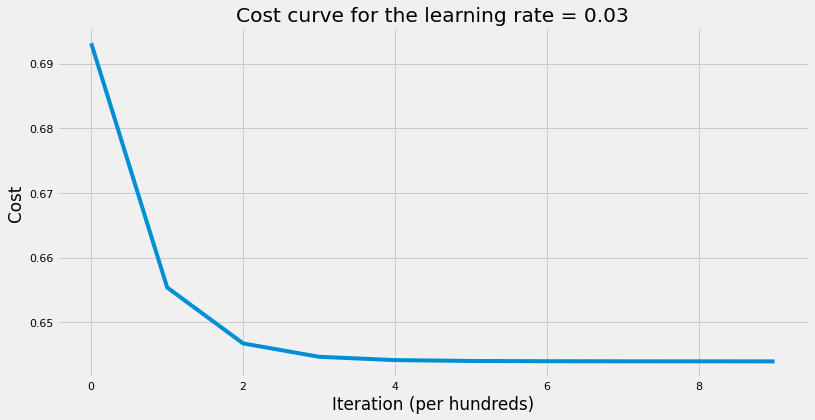

In [5]:
# setup layers dimensions, number of examples, and keep probabilities list
m = X_train.shape[0]
keep_prob = [1, 1, 1, 1]
layers_dims = [m, 10, 10, 1]

# train NN with no dropout
parameters = model_with_dropout(
    X_train,
    Y_train,
    layers_dims,
    keep_prob=keep_prob,
    learning_rate=0.03,
    num_iterations=1000,
    hidden_layers_activation_fn="relu",
)

# print the test accuracy
print(
    "The training accuracy rate: {}".format(
        accuracy(X_train, parameters, Y_train, "relu")[-7:]
    )
)
print(
    "The test accuracy rate: {}".format(
        accuracy(X_test, parameters, Y_test, "relu")[-7:]
    )
)

The cost after 100 iterations : 0.6555.
The cost after 200 iterations : 0.6467.
The cost after 300 iterations : 0.6445.
The cost after 400 iterations : 0.6437.
The cost after 500 iterations : 0.6412.
The cost after 600 iterations : 0.6338.
The cost after 700 iterations : 0.6108.
The cost after 800 iterations : 0.5367.
The cost after 900 iterations : 0.4322.
The cost after 1000 iterations : 0.3114.
The training accuracy rate: 74.16%.
The test accuracy rate: 44.00%.


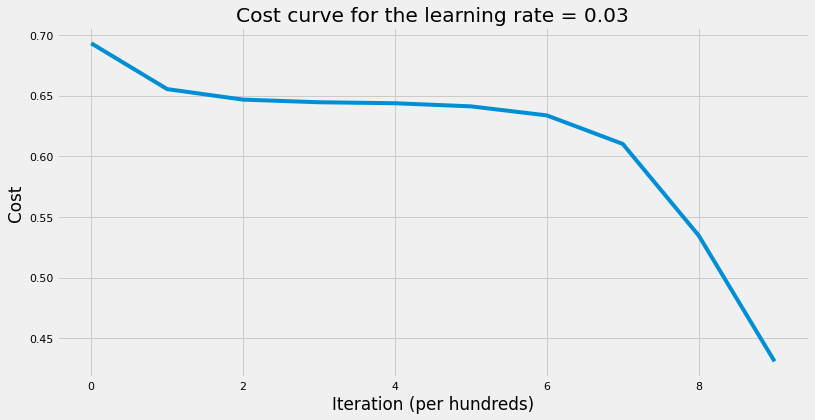

In [6]:
# setup keep probabilities list
keep_prob = [1, 0.5, 0.5, 1]

# train NN with no dropout
parameters = model_with_dropout(
    X_train,
    Y_train,
    layers_dims,
    keep_prob=keep_prob,
    learning_rate=0.03,
    num_iterations=1000,
    hidden_layers_activation_fn="relu",
)

# print the test accuracy
print(
    "The training accuracy rate: {}".format(
        accuracy(X_train, parameters, Y_train, "relu")[-7:]
    )
)
print(
    "The test accuracy rate: {}".format(
        accuracy(X_test, parameters, Y_test, "relu")[-7:]
    )
)

As the results above showed, the network with dropout improved on test accuracy rate by 30%. Note that this is just an illustrative example to show the effectiveness of the dropout technique. We chose an arbitrary probabilities in this example; however, we can tune the dropout probabilities on each layer to yield the best validation loss and accuracy. 

## Conclusion

Dropout is a very effective regularization technique that is used a lot in *Convolutional Neural Networks*. Below are some takeaways:

- Set `keep_prob = 1` when using gradient checking; otherwise, it won't work.
- Dropout is used only during training. Don't use it when testing/predicting new examples.
- The lowest the `keep_prob` $\rightarrow$ the simpler the neural network. As `keep_prob` decreases, the bias increases and the variance decreases. Therefore, layers with more neurons are expected to have lower `keep_prob` to avoid overfitting.
- It's computationally a cheap way to improve generalization error and help resolve overfitting.
- One can tune `keep_prob` to get the best results out of the task at hand.